<a href="https://colab.research.google.com/github/meltyyyyy/kaggle-amex/blob/main/Notebooks/CatBoost/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class Config:
    name = "CatBoost/Baseline"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None

In [ ]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

In [ ]:
COLAB = "google.colab" in sys.modules
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    # import library
    ! pip install --quiet catboost
    # ! pip install --quiet iterative-stratification
    # ! pip install --quiet tensorflow-addons

    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = Config.drive_path
    EXP = (Config.name if Config.name is not None 
           else get("http://172.28.0.2:9000/api/sessions").json()[0]["name"][:-6])
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SUBMISSION = os.path.join(DRIVE, "Submission")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP) 
    EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)

    # if not os.path.isfile(os.path.join(INPUT, "amex-default-prediction.zip")):
        # load dataset
        # ! kaggle competitions download -c amex-default-prediction -p $INPUT 
else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT = "../input/amex-default-prediction"
    EXP, OUTPUT, SUBMISSION = "./", "./", "./"
    EXP_MODEL = os.path.join(EXP, "model")
    EXP_FIG = os.path.join(EXP, "fig")
    EXP_PREDS = os.path.join(EXP, "preds")
    
    # copy dirs
    if Config.kaggle_dataset_path is not None:
        KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
        KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
        shutil.copytree(KD_MODEL, EXP_MODEL)
        shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # make dirs
    for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)


This environment is Google Colab


In [ ]:
with open(os.path.join(INPUT, 'data_types.json'), "r") as rf:
    dtypes = json.load(rf)
train = pd.read_parquet(os.path.join(INPUT, 'train.parquet') if COLAB else 'train.parquet')
train = train.astype(dtypes)
target = pd.read_csv(os.path.join(INPUT, 'train_labels.csv') if COLAB else 'train_labels.csv', dtype={'customer_ID': 'str', 'target': 'int8'})
# train = pd.read_parquet(os.path.join(INPUT, 'train_small.parquet') if COLAB else 'train_small.parquet')
test = pd.read_parquet(os.path.join(INPUT, 'test.parquet') if COLAB else 'test.parquet')
test = test.astype(dtypes)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: category(2), datetime64[ns](1), float16(185), int8(1), object(1)
memory usage: 2.0+ GB


In [ ]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827


## Evaluation merics

In [ ]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

class AmexMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        # the larger metric value the better
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        preds = np.array(approxes[0])
        target = np.array(target)
        return amex_metric(pd.DataFrame({'target': target}), pd.Series(preds, name='prediction')), 0

## Preprocess

In [ ]:
train = train.groupby('customer_ID')\
  .tail(1).set_index('customer_ID', drop=True)\
  .sort_index()\
  .merge(target.set_index('customer_ID', drop=True), left_index=True, right_index=True)
test =  test.groupby('customer_ID')\
  .tail(1).set_index('customer_ID', drop=True)\
  .sort_index()

## Select features to use

In [ ]:
features = []
unuse = ['customer_ID', 'S_2', 'target']
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

features = [col for col in train.columns if col not in unuse]

# convert categorical features into string for catboost training
for col in categorical:
  train[col] = train[col].astype('str')
  test[col] = test[col].astype('str')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 190 entries, S_2 to target
dtypes: datetime64[ns](1), float16(176), int8(2), object(11)
memory usage: 200.4+ MB


## Training

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

def fit_catboost(X, y, cat_features=None, params=None):
  models = []
  scores = []

  skf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
  
  for fold, (train_indices, valid_indices) in enumerate(tqdm(skf.split(X, y))):
    print("-"*50+f' fold{fold} '+'-'*50)
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

    model = CatBoostClassifier(**params,
                               cat_features=cat_features,
                               eval_metric=AmexMetric(),
                              #  task_type='GPU',
                               iterations=10000,
                               random_seed=Config.seed,
                               verbose=0)
    
    model.fit(X_train, y_train,
              cat_features=cat_features,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose_eval=50)
    
    # ------------------- prediction -------------------
    pred = model.predict_proba(X_valid)[:, 1]
    score = amex_metric(pd.DataFrame({'target': y_valid.values}), pd.Series(pred, name='prediction'))

    # ------------------- save -------------------
    file = f'{EXP_MODEL}/catboost_fold{fold}.pkl'
    model.save_model(file, format='cbm')
    scores.append(score)
    models.append(model)
    print(f'fold{fold} amex meric: {score}')
    print()

  print(f"OOF Score: {np.mean(scores):.5f}")
  return models

def inference_catboost(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred

In [ ]:
cat_params = {"learning_rate": 0.01}

models = fit_catboost(train[features], train[Config.target], cat_features=categorical, params=cat_params)
# models = [joblib.load(f'{EXP_MODEL}/lgbm_fold{i}.pkl') for i in range(Config.n_splits)]
pred = inference_catboost(models, test[features])

0it [00:00, ?it/s]

-------------------------------------------------- fold0 --------------------------------------------------
0:	learn: 0.6769880	test: 0.6766425	test1: 0.6745639	best: 0.6745639 (0)	total: 1.81s	remaining: 5h 2m 23s
50:	learn: 0.7319654	test: 0.7319652	test1: 0.7283773	best: 0.7283773 (50)	total: 1m 27s	remaining: 4h 46m 4s
100:	learn: 0.7424655	test: 0.7424655	test1: 0.7388525	best: 0.7389936 (98)	total: 2m 55s	remaining: 4h 45m 56s
150:	learn: 0.7508101	test: 0.7508101	test1: 0.7469790	best: 0.7469790 (150)	total: 4m 21s	remaining: 4h 44m 3s
200:	learn: 0.7564429	test: 0.7564429	test1: 0.7532350	best: 0.7532350 (200)	total: 5m 46s	remaining: 4h 41m 47s
250:	learn: 0.7612781	test: 0.7612781	test1: 0.7573785	best: 0.7573785 (250)	total: 7m 12s	remaining: 4h 40m 2s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7578947893
bestIteration = 256

Shrink model to first 257 iterations.
fold0 amex meric: 0.757894789319144

-------------------------------------------------- 

## Plot importances

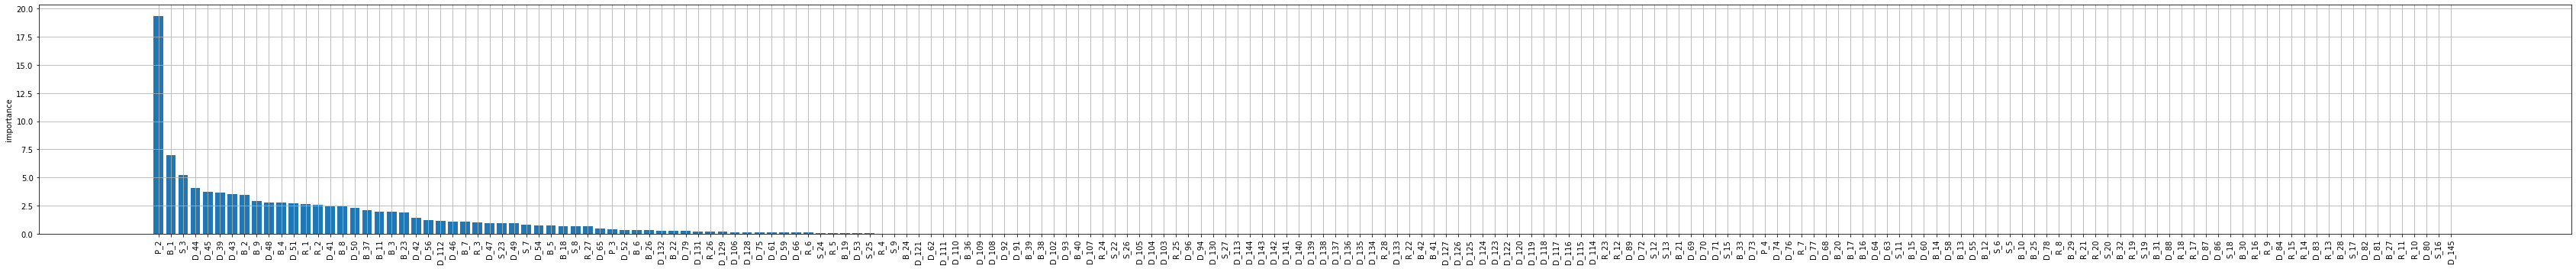

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

## Submission

In [ ]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': pred})
sub.to_csv(f'{SUBMISSION}/submission.csv', index=False)

In [ ]:
! kaggle competitions submit -c amex-default-prediction -f /content/drive/MyDrive/workspace/kaggle-amex/Submission/submission.csv -m "CatBoost Baseline"

100% 74.7M/74.7M [00:01<00:00, 45.2MB/s]
Successfully submitted to American Express - Default Prediction